/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore




Sim time: 0, Dt: 0.5
sticking: 258, sliding: 0, open: 0


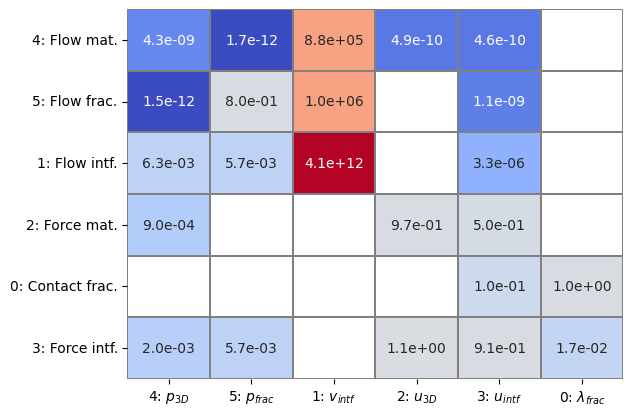

In [1]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
from models import make_model
import porepy as pp


model = make_model(
    {
        "physics": 1,
        "geometry": 3,
        "barton_bandis_stiffness_type": 2,
        "friction_type": 1,
        "grid_refinement": 1,
        "solver": 2,
    }
)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model.assemble_linear_system()
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(load_data(f'../stats/{model.simulation_name()}.json'), 1)
model.linear_system = mat, rhs
model.bmat.mat = mat

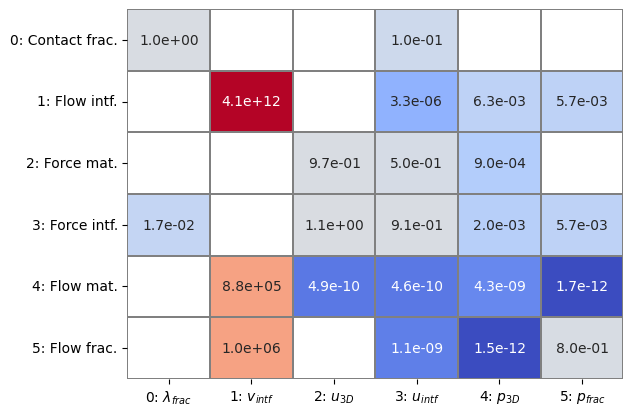

In [3]:
J = model.bmat[:]
J.plot_max()

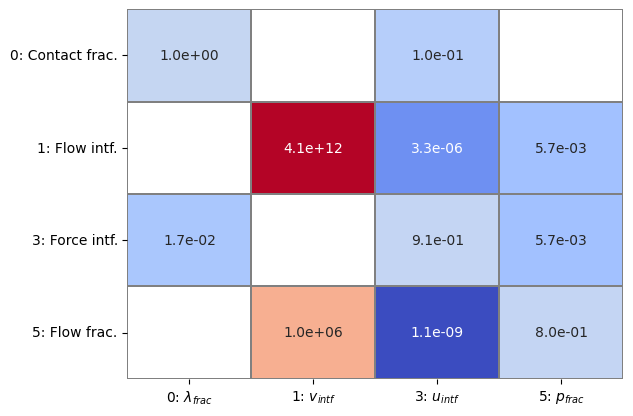

In [4]:
J[[0, 1, 3, 5]].plot_max()

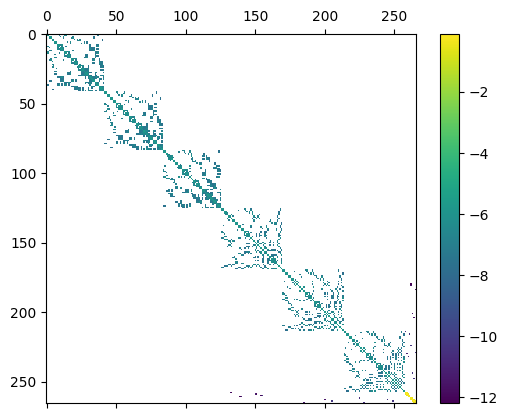

In [5]:
J[[5]].matshow()

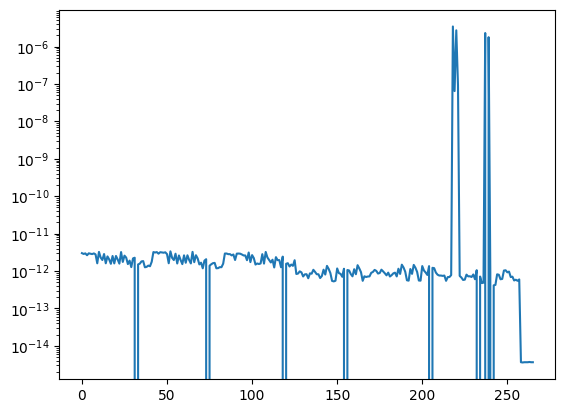

In [6]:
plt.plot(np.array(J[[5]].mat.sum(0)).ravel())
plt.yscale('log')

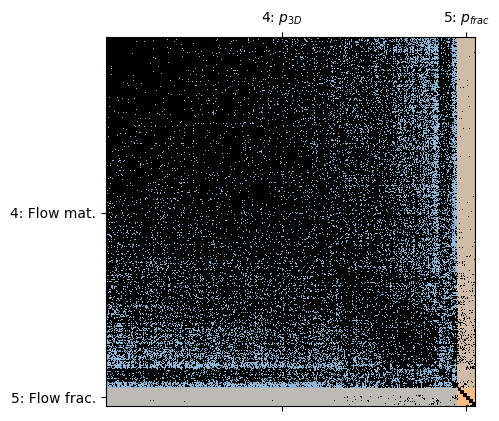

In [10]:
J[[4, 5]].color_spy()

Solve  took: 0.02
True residual: 2.7603399611486688e-06
PETSc Converged Reason: 3


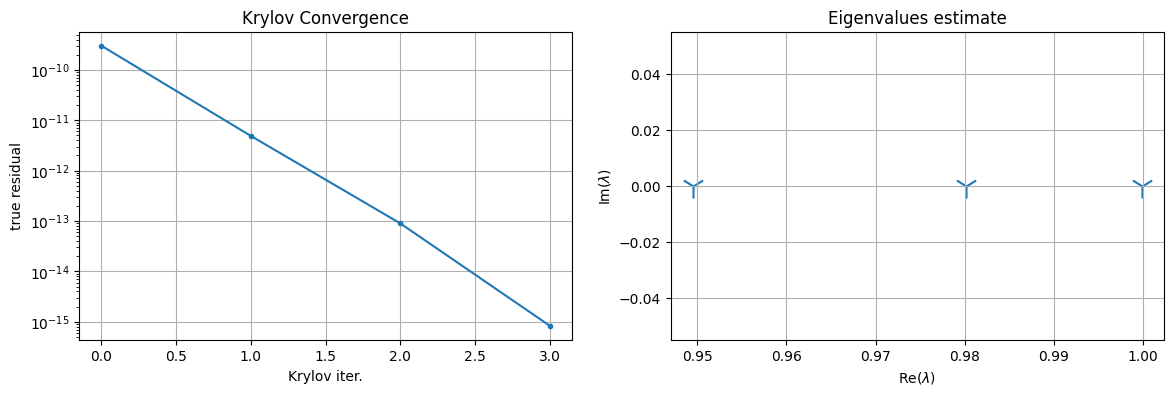

In [12]:
from fixed_stress import make_fs_analytical
from hm_solver import build_mechanics_near_null_space
from mat_utils import *
from block_matrix import *


# p = [6, 7]
# t = [8, 9, 10]
t = [4, 5]

def tmp(bmat: BlockMatrixStorage):
    res = bmat.empty_container()
    res.mat = inv_block_diag(bmat.mat, nd=1, lump=True)
    return res

solve_petsc_3(
    J,
    rhs_global=rhs,
    ksp_scheme=KSPScheme(
        right_transformations=[
            # lambda bmat: make_right_decoupling_operator(bmat, groups0=t, groups1=p),
        ],
        left_transformations=[
            # lambda bmat: make_left_decoupling_operator(bmat, groups0=p, groups1=t),
            # lambda bmat: tmp(bmat),
        ],
        preconditioner=FieldSplitScheme(
            groups=t,
            # solve=lambda bmat: PetscILU(bmat.mat, factor_levels=0),
            solve=lambda bmat: PetscAMGFlow(bmat.mat)
        ),
    ),
)